In [ ]:
!pip install kaggle pretty_midi torch torchvision torchaudio scikit-learn matplotlib tqdm torchcodec torchlibrosa > /dev/null

from google.colab import drive
drive.mount('/content/drive')

import os, re, json, glob, zipfile, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1) Konfigurasi path & unduh ZIP
# -------------------------
FILE_ID = "1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA"   # ID ZIP gabungan (punyamu)
ZIP_PATH = Path("/content/dataset_mirex.zip")
EXTRACT_DIR = Path("/content/dataset_mirex")    # root ekstraksi

SAVE_DIR = Path("/content/drive/MyDrive/dataset_mirex/audiotrainX")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

import gdown
if not ZIP_PATH.exists():
    print("Downloading ZIP via gdown...")
    gdown.download(id=FILE_ID, output=str(ZIP_PATH), quiet=False)
else:
    print("ZIP already exists:", ZIP_PATH)

print("Extracting ZIP ...")
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

print("Done extract.")
print("EXTRACT_DIR content:")
for p in EXTRACT_DIR.iterdir():
    print(" -", p)

Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?id=1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA
From (redirected): https://drive.google.com/uc?id=1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA&confirm=t&uuid=16b8f1f5-ad2f-402f-bc5f-4bf3ca3c97cf
To: /content/dataset_mirex.zip
100%|██████████| 320M/320M [00:08<00:00, 36.4MB/s]


Extracting ZIP ...
Done extract.
EXTRACT_DIR content:
 - /content/dataset_mirex/dataset
 - /content/dataset_mirex/README.txt


In [ ]:
from pathlib import Path
import os

EXTRACT_DIR = Path("/content/dataset_mirex")

# Cari folder yang punya subfolder Audio, Lyrics, MIDIs
candidates = []
for root, dirs, files in os.walk(EXTRACT_DIR):
    dirs_set = set(dirs)
    if {"Audio", "Lyrics", "MIDIs"}.issubset(dirs_set):
        candidates.append(Path(root))

if not candidates:
    raise RuntimeError("Gak nemu folder yang berisi Audio, Lyrics, MIDIs di bawah /content/dataset_mirex")

ROOT = candidates[0]
AUDIO_DIR = ROOT / "Audio"
LYRIC_DIR = ROOT / "Lyrics"
MIDI_DIR  = ROOT / "MIDIs"

print("ROOT terdeteksi :", ROOT)
print("AUDIO_DIR       :", AUDIO_DIR)
print("LYRIC_DIR       :", LYRIC_DIR)
print("MIDI_DIR        :", MIDI_DIR)

# Cari file .bat di bawah ROOT
BAT_FILES = sorted(ROOT.rglob("split-by-categories*.bat"))
print("\nBAT_FILES ditemukan:", len(BAT_FILES))
for b in BAT_FILES:
    print(" -", b)


ROOT terdeteksi : /content/dataset_mirex/dataset
AUDIO_DIR       : /content/dataset_mirex/dataset/Audio
LYRIC_DIR       : /content/dataset_mirex/dataset/Lyrics
MIDI_DIR        : /content/dataset_mirex/dataset/MIDIs

BAT_FILES ditemukan: 3
 - /content/dataset_mirex/dataset/split-by-categories-audio.bat
 - /content/dataset_mirex/dataset/split-by-categories-lyrics.bat
 - /content/dataset_mirex/dataset/split-by-categories-midi.bat


In [ ]:
import pandas as pd

DRIVE_DATASET_DIR = Path("/content/drive/MyDrive/dataset_mirex")
DATASET_ROOT = EXTRACT_DIR   # /content/dataset_mirex

master_tracks = pd.read_csv(DRIVE_DATASET_DIR / "master_tracks.csv")
split_global  = pd.read_csv(DRIVE_DATASET_DIR / "split_global.csv")

print("master_tracks:", master_tracks.shape)
print("split_global :", split_global.shape)
master_tracks.head()


master_tracks: (903, 8)
split_global : (903, 2)


,file_id,file_id_norm,emotion,label_id,label_idx,has_audio,has_lyrics,has_midi
0,1,1,Cluster 1,1,0,1,1,0
1,2,2,Cluster 1,1,0,1,0,0
2,3,3,Cluster 1,1,0,1,1,0
3,4,4,Cluster 1,1,0,1,1,1
4,5,5,Cluster 1,1,0,1,0,0


In [ ]:
# merge master_tracks dengan split_global
df = master_tracks.merge(split_global, left_on="file_id_norm", right_on="id", how="inner")

# filter hanya yang ada audio
df_audio = df[df["has_audio"] == 1].copy()

# tambahkan path audio
df_audio["audio_path"] = df_audio["file_id"].apply(
    lambda x: AUDIO_DIR / f"{int(x):03d}.mp3"
)

print("Total audio:", len(df_audio))
df_audio.head()


Total audio: 903


,file_id,file_id_norm,emotion,label_id,label_idx,has_audio,has_lyrics,has_midi,id,split,audio_path
0,1,1,Cluster 1,1,0,1,1,0,1,train,/content/dataset_mirex/dataset/Audio/001.mp3
1,2,2,Cluster 1,1,0,1,0,0,2,val,/content/dataset_mirex/dataset/Audio/002.mp3
2,3,3,Cluster 1,1,0,1,1,0,3,train,/content/dataset_mirex/dataset/Audio/003.mp3
3,4,4,Cluster 1,1,0,1,1,1,4,train,/content/dataset_mirex/dataset/Audio/004.mp3
4,5,5,Cluster 1,1,0,1,0,0,5,train,/content/dataset_mirex/dataset/Audio/005.mp3


In [ ]:
missing = [p for p in df_audio["audio_path"] if not p.exists()]
print("Missing audio files:", len(missing))
missing[:10]


Missing audio files: 0


[]

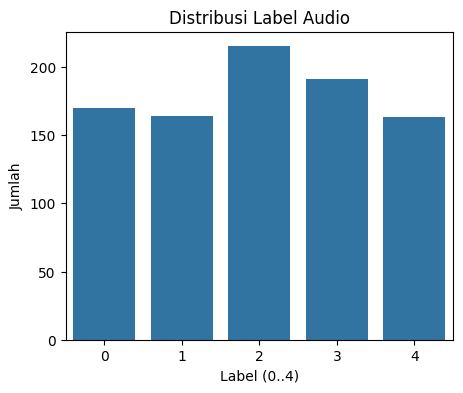

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.countplot(x="label_idx", data=df_audio)
plt.title("Distribusi Label Audio")
plt.xlabel("Label (0..4)")
plt.ylabel("Jumlah")
plt.show()


Sample audio: /content/dataset_mirex/dataset/Audio/001.mp3


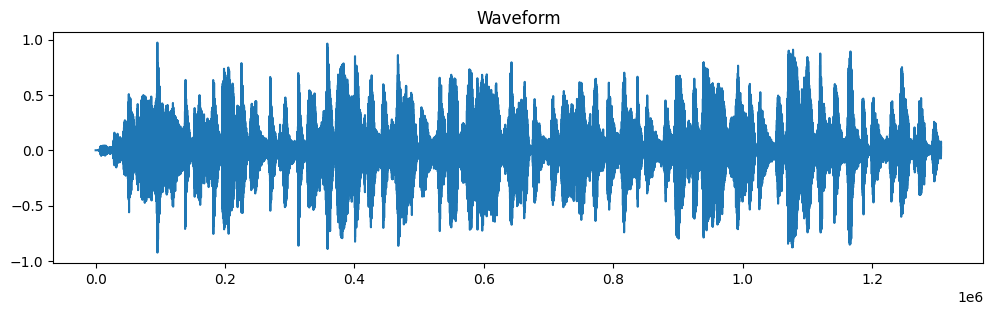

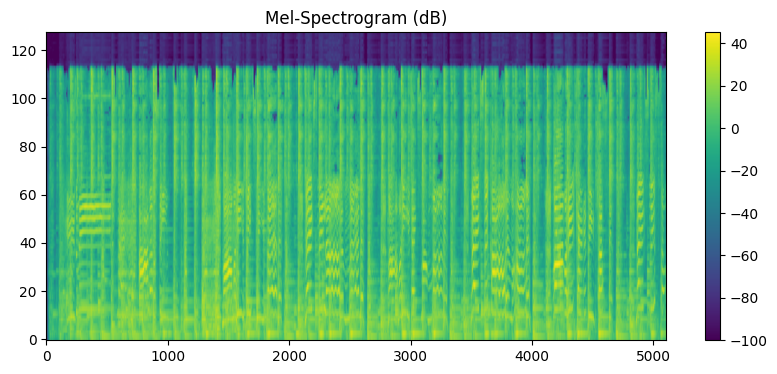

In [ ]:
!pip install torchcodec > /dev/null
import torchaudio  # reload setelah install

import torchaudio
import matplotlib.pyplot as plt

sample_path = df_audio["audio_path"].iloc[0]
print("Sample audio:", sample_path)

wav, sr = torchaudio.load(sample_path)
wav = wav.mean(dim=0, keepdim=True)  # mono

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050, n_fft=1024, hop_length=256, n_mels=128
)
amp_to_db = torchaudio.transforms.AmplitudeToDB()

mel = mel_transform(wav)
mel_db = amp_to_db(mel)

plt.figure(figsize=(12,3))
plt.plot(wav[0].numpy())
plt.title("Waveform")
plt.show()

plt.figure(figsize=(10,4))
plt.imshow(mel_db[0].numpy(), aspect="auto", origin="lower")
plt.title("Mel-Spectrogram (dB)")
plt.colorbar()
plt.show()


In [ ]:
train_df = df_audio[df_audio["split"]=="train"].reset_index(drop=True)
val_df   = df_audio[df_audio["split"]=="val"].reset_index(drop=True)
test_df  = df_audio[df_audio["split"]=="test"].reset_index(drop=True)

train_df["label"] = train_df["label_idx"].astype(int)
val_df["label"]   = val_df["label_idx"].astype(int)
test_df["label"]  = test_df["label_idx"].astype(int)

print(len(train_df), len(val_df), len(test_df))


722 90 91


In [ ]:
import gdown
import torch
import torch.nn as nn
import sys
from pathlib import Path

# Define REPO_DIR and clone the PANNs repository if it doesn't exist
REPO_DIR = Path("/content/audioset_tagging_cnn")

if not REPO_DIR.exists():
    print(f"Cloning audioset_tagging_cnn to {REPO_DIR}...")
    !git clone https://github.com/qiuqiangkong/audioset_tagging_cnn.git $REPO_DIR
    print("Cloning complete.")
else:
    print(f"PANNs repository already exists: {REPO_DIR}")

# Add PANNs directories to sys.path for imports
if str(REPO_DIR) not in sys.path:
    sys.path.insert(0, str(REPO_DIR))
if str(REPO_DIR / "pytorch") not in sys.path:
    sys.path.insert(0, str(REPO_DIR / "pytorch"))

# Define device and NUM_CLASSES
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 5  # From previous cell context

# Import Cnn14 after adding to sys.path
from models import Cnn14

# URL for the Cnn14 pre-trained checkpoint from Zenodo
CHECKPOINT_URL = "https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth"
CHECKPOINT_PATH = Path(REPO_DIR) / "Cnn14_mAP=0.431.pth"

# Download checkpoint if it doesn't exist
if not CHECKPOINT_PATH.exists():
    print(f"Downloading Cnn14 checkpoint to {CHECKPOINT_PATH}...")
    gdown.download(CHECKPOINT_URL, str(CHECKPOINT_PATH), quiet=False)
else:
    print(f"Cnn14 checkpoint already exists: {CHECKPOINT_PATH}")

# Re-instantiate the Cnn14 model with its original number of classes (527)
# This is necessary to load the full pre-trained checkpoint without mismatch errors.
panns_model = Cnn14(sample_rate=32000, window_size=1024,
                    hop_size=320, mel_bins=64, fmin=50, fmax=14000,
                    classes_num=527)
panns_model.to(device)

# Load the pre-trained state dictionary
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
panns_model.load_state_dict(checkpoint["model"]) # Corrected key from "model_state_dict" to "model"

print("Pre-trained Cnn14 weights loaded.")

# Now, replace the final classification layer for our 5-class task
original_fc_in_features = panns_model.fc_audioset.in_features
panns_model.fc_audioset = nn.Linear(original_fc_in_features, NUM_CLASSES)
panns_model.to(device)

print("PANNs Cnn14 model loaded with pre-trained weights and adapted for 5 classes.")
print(f"New final layer: {panns_model.fc_audioset}")

PANNs repository already exists: /content/audioset_tagging_cnn
Cnn14 checkpoint already exists: /content/audioset_tagging_cnn/Cnn14_mAP=0.431.pth
Pre-trained Cnn14 weights loaded.
PANNs Cnn14 model loaded with pre-trained weights and adapted for 5 classes.
New final layer: Linear(in_features=2048, out_features=5, bias=True)


In [ ]:
import gdown

# URL for the Cnn14 pre-trained checkpoint from Zenodo
CHECKPOINT_URL = "https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth"
CHECKPOINT_PATH = Path(REPO_DIR) / "Cnn14_mAP=0.431.pth"

# Download checkpoint if it doesn't exist
if not CHECKPOINT_PATH.exists():
    print(f"Downloading Cnn14 checkpoint to {CHECKPOINT_PATH}...")
    gdown.download(CHECKPOINT_URL, str(CHECKPOINT_PATH), quiet=False)
else:
    print(f"Cnn14 checkpoint already exists: {CHECKPOINT_PATH}")

# Re-instantiate the Cnn14 model with its original number of classes (527)
# This is necessary to load the full pre-trained checkpoint without mismatch errors.
panns_model = Cnn14(sample_rate=32000, window_size=1024,
                    hop_size=320, mel_bins=64, fmin=50, fmax=14000,
                    classes_num=527)
panns_model.to(device)

# Load the pre-trained state dictionary using the correct key 'model'
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
panns_model.load_state_dict(checkpoint["model"])

print("Pre-trained Cnn14 weights loaded.")

# Now, replace the final classification layer for our 5-class task
original_fc_in_features = panns_model.fc_audioset.in_features
panns_model.fc_audioset = nn.Linear(original_fc_in_features, NUM_CLASSES)
panns_model.to(device)

print("PANNs Cnn14 model loaded with pre-trained weights and adapted for 5 classes.")
print(f"New final layer: {panns_model.fc_audioset}")

Cnn14 checkpoint already exists: /content/audioset_tagging_cnn/Cnn14_mAP=0.431.pth
Pre-trained Cnn14 weights loaded.
PANNs Cnn14 model loaded with pre-trained weights and adapted for 5 classes.
New final layer: Linear(in_features=2048, out_features=5, bias=True)


In [ ]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import random
import torch
import torchaudio # Explicitly import torchaudio

# PANNs specific parameters for the dataset
PANN_SAMPLE_RATE = 32000 # Cnn14 model's expected sample rate
PANN_TARGET_AUDIO_LENGTH = PANN_SAMPLE_RATE * 10 # Example: 10 seconds of audio

class AudioDataset(Dataset):
    def __init__(self, df, split: str, target_audio_length: int = PANN_TARGET_AUDIO_LENGTH):
        self.paths = df["audio_path"].tolist()
        self.labels = df["label"].tolist()
        self.split = split  # "train" / "val" / "test"
        self.target_audio_length = target_audio_length

    def __len__(self):
        return len(self.paths)

    def _pad_audio(self, wav):
        """
        Pads audio to target_audio_length if it's shorter.
        wav: (1, T_audio)
        return: (1, target_audio_length)
        """
        _, T_audio = wav.shape
        if T_audio < self.target_audio_length:
            pad_len = self.target_audio_length - T_audio
            wav = F.pad(wav, (0, pad_len))
        return wav

    def _get_random_crop_or_pad_audio(self, wav):
        """
        Random crop for training, or pad if T_audio < target_audio_length.
        wav: (1, T_audio)
        return: (1, target_audio_length)
        """
        _, T_audio = wav.shape
        if T_audio == self.target_audio_length:
            return wav

        if T_audio > self.target_audio_length:
            # random crop
            start = random.randint(0, T_audio - self.target_audio_length)
            wav = wav[:, start : start + self.target_audio_length]
        else:
            # pad if shorter than target_audio_length
            wav = self._pad_audio(wav)
        return wav

    def _get_multicrops_audio(self, wav):
        """
        Generates fixed-size crops (start, middle, end) for validation/test.
        Pads individual crops if necessary.
        wav: (1, T_audio)
        return: (num_crops, 1, target_audio_length)
        """
        _, T_audio = wav.shape
        crops = []

        if T_audio <= self.target_audio_length:
            # If audio is shorter or equal to target_audio_length, just pad and take one 'crop'
            cropped_wav = self._pad_audio(wav)
            crops.append(cropped_wav)
        else:
            # Calculate start indices for 3 crops: start, middle, end
            starts = [
                0,
                (T_audio - self.target_audio_length) // 2,
                T_audio - self.target_audio_length
            ]
            for start in starts:
                cropped_wav = wav[:, start : start + self.target_audio_length]
                crops.append(cropped_wav)

        # Stack crops along a new dimension
        return torch.stack(crops, dim=0) # (num_crops, 1, target_audio_length)

    def __getitem__(self, idx):
        path = str(self.paths[idx])
        label = self.labels[idx]

        wav, sr = torchaudio.load(path)

        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True) # Convert to mono (1, T_audio)

        # Resample to PANNs model's expected sample rate
        wav = torchaudio.functional.resample(wav, sr, PANN_SAMPLE_RATE)

        if self.split == "train":
            processed_wav = self._get_random_crop_or_pad_audio(wav)  # (1, PANN_TARGET_AUDIO_LENGTH)
            # Squeeze channel dim: PANNs Cnn14 expects (batch_size, audio_samples)
            processed_wav = processed_wav.squeeze(0) # (PANN_TARGET_AUDIO_LENGTH)
        else: # val or test
            processed_wav = self._get_multicrops_audio(wav)  # (num_crops, 1, PANN_TARGET_AUDIO_LENGTH)
            # Squeeze channel dim for multi-crop PANNs input
            processed_wav = processed_wav.squeeze(1) # (num_crops, PANN_TARGET_AUDIO_LENGTH)

        return processed_wav, torch.tensor(label)

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

NUM_CLASSES = 5

# ========== HITUNG SAMPLER WEIGHT ==========
labels_train = train_df["label"].values
class_counts = np.bincount(labels_train, minlength=NUM_CLASSES)

print("Class counts:", class_counts)

class_weights = 1.0 / (class_counts + 1e-6)
sample_weights = class_weights[labels_train]

sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# ========== DATASET BARU DENGAN SPLIT ==========
train_dataset = AudioDataset(train_df, split="train")
val_dataset   = AudioDataset(val_df,   split="val")
test_dataset  = AudioDataset(test_df,  split="test")

# ========== DATALOADER ==========
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False)

print("DataLoaders re-initialized with multi-crop audio support.")

Class counts: [136 131 172 153 130]
DataLoaders re-initialized with multi-crop audio support.


In [ ]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
from tqdm.auto import tqdm
import torch.nn as nn
from transformers import get_linear_schedule_with_warmup # Import the scheduler

# Define missing variables
EPOCHS = 20  # Define the number of epochs
patience = 3 # Define patience for early stopping
criterion = nn.CrossEntropyLoss() # Define the loss function

best_val_f1 = 0.0
patience_counter = 0

# Re-initialize history for PANNs training
history_pann = {
    "epoch": [],
    "lr": [],
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_f1": [],
    "val_f1": [],
    "train_prec": [],
    "val_prec": [],
    "train_rec": [],
    "val_rec": [],
}

# Reset optimizer and scheduler for PANNs model
# Assuming a new optimizer and scheduler are needed for the PANNs model
optimizer_pann = torch.optim.Adam(panns_model.parameters(), lr=1e-4)
num_training_steps_pann = len(train_loader) * EPOCHS
scheduler_pann = get_linear_schedule_with_warmup(
    optimizer_pann,
    num_warmup_steps=int(0.1 * num_training_steps_pann),
    num_training_steps=num_training_steps_pann
)

print(f"Starting training for PANNs model for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

    # ------------- TRAIN -------------
    panns_model.train()
    total_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for audio_samples, labels in tqdm(train_loader, desc=f"Train {epoch+1}"):
        # audio_samples for train is (batch_size, PANN_TARGET_AUDIO_LENGTH)
        audio_samples = audio_samples.to(device)
        labels = labels.to(device)

        outputs_dict = panns_model(audio_samples)
        outputs = outputs_dict["clipwise_output"] # Extract the clipwise_output
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_pann.step()
        scheduler_pann.step()
        optimizer_pann.zero_grad()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.detach().cpu().numpy())
        all_train_labels.extend(labels.detach().cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)
    train_acc  = accuracy_score(all_train_labels, all_train_preds)
    train_f1   = f1_score(all_train_labels, all_train_preds, average="macro")
    train_prec = precision_score(all_train_labels, all_train_preds, average="macro", zero_division=0)
    train_rec  = recall_score(all_train_labels, all_train_preds, average="macro", zero_division=0)
    current_lr = scheduler_pann.get_last_lr()[0]

    print(f"Train loss : {avg_train_loss:.4f} | "
          f"acc: {train_acc:.4f} | "
          f"F1: {train_f1:.4f} | "
          f"prec: {train_prec:.4f} | "
          f"rec: {train_rec:.4f} | "
          f"lr: {current_lr:.6f}")

    # ------------- VALIDATION -------------
    panns_model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for audio_multicrop, labels in tqdm(val_loader, desc="Val"):
            # audio_multicrop for val/test is (batch_size, num_crops, PANN_TARGET_AUDIO_LENGTH)
            labels = labels.to(device)

            num_crops = audio_multicrop.shape[1]
            # Reshape from (batch_size, num_crops, PANN_TARGET_AUDIO_LENGTH) to (batch_size * num_crops, PANN_TARGET_AUDIO_LENGTH)
            reshaped_input = audio_multicrop.view(-1, PANN_TARGET_AUDIO_LENGTH).to(device)

            # Pass through model
            outputs_all_crops_dict = panns_model(reshaped_input)
            outputs_all_crops = outputs_all_crops_dict["clipwise_output"] # Extract the clipwise_output

            # Reshape back to (batch_size, num_crops, NUM_CLASSES) and average across crops
            outputs_per_sample = outputs_all_crops.view(-1, num_crops, NUM_CLASSES)
            avg_outputs = outputs_per_sample.mean(dim=1) # (batch_size, NUM_CLASSES)

            loss = criterion(avg_outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(avg_outputs, dim=1)
            all_val_preds.extend(preds.detach().cpu().numpy())
            all_val_labels.extend(labels.detach().cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc  = accuracy_score(all_val_labels, all_val_preds)
    val_f1   = f1_score(all_val_labels, all_val_preds, average="macro")
    val_prec = precision_score(all_val_labels, all_val_preds, average="macro", zero_division=0)
    val_rec  = recall_score(all_val_labels, all_val_preds, average="macro", zero_division=0)

    print(f"Val   loss : {avg_val_loss:.4f} | "
          f"acc: {val_acc:.4f} | "
          f"F1: {val_f1:.4f} | "
          f"prec: {val_prec:.4f} | "
          f"rec: {val_rec:.4f}")

    # simpan history
    history_pann["epoch"].append(epoch+1)
    history_pann["lr"].append(current_lr)
    history_pann["train_loss"].append(avg_train_loss)
    history_pann["val_loss"].append(avg_val_loss)
    history_pann["train_acc"].append(train_acc)
    history_pann["val_acc"].append(val_acc)
    history_pann["train_f1"].append(train_f1)
    history_pann["val_f1"].append(val_f1)
    history_pann["train_prec"].append(train_prec)
    history_pann["val_prec"].append(val_prec)
    history_pann["train_rec"].append(train_rec)
    history_pann["val_rec"].append(val_rec)

    # ------------- EARLY STOPPING -------------
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(panns_model.state_dict(), DATASET_ROOT / "best_audio_pann.pt")
        print(f"✅ Model improved (val F1={val_f1:.4f}), saved.")
    else:
        patience_counter += 1
        print(f"No improvement, patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹ Early stopping.")
            break

print("Training finished for PANNs model.")

Starting training for PANNs model for 20 epochs...

=== Epoch 1/20 ===


Train 1:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.6174 | acc: 0.2064 | F1: 0.1167 | prec: 0.4159 | rec: 0.2097 | lr: 0.000050


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.6022 | acc: 0.2111 | F1: 0.1133 | prec: 0.1062 | rec: 0.2257
✅ Model improved (val F1=0.1133), saved.

=== Epoch 2/20 ===


Train 2:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5980 | acc: 0.2548 | F1: 0.1847 | prec: 0.3388 | rec: 0.2593 | lr: 0.000100


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5887 | acc: 0.3111 | F1: 0.2227 | prec: 0.3832 | rec: 0.3323
✅ Model improved (val F1=0.2227), saved.

=== Epoch 3/20 ===


Train 3:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5843 | acc: 0.3546 | F1: 0.3239 | prec: 0.4591 | rec: 0.3481 | lr: 0.000094


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5625 | acc: 0.4444 | F1: 0.3551 | prec: 0.3273 | rec: 0.4443
✅ Model improved (val F1=0.3551), saved.

=== Epoch 4/20 ===


Train 4:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5298 | acc: 0.4058 | F1: 0.3446 | prec: 0.3811 | rec: 0.3919 | lr: 0.000089


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.4644 | acc: 0.4444 | F1: 0.3216 | prec: 0.2829 | rec: 0.4280
No improvement, patience 1/3

=== Epoch 5/20 ===


Train 5:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.4604 | acc: 0.4280 | F1: 0.3841 | prec: 0.4173 | rec: 0.4159 | lr: 0.000083


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.4269 | acc: 0.4333 | F1: 0.3367 | prec: 0.3517 | rec: 0.4142
No improvement, patience 2/3

=== Epoch 6/20 ===


Train 6:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.4273 | acc: 0.4321 | F1: 0.4232 | prec: 0.4248 | rec: 0.4384 | lr: 0.000078


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.3934 | acc: 0.4556 | F1: 0.4015 | prec: 0.4261 | rec: 0.4348
✅ Model improved (val F1=0.4015), saved.

=== Epoch 7/20 ===


Train 7:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.3919 | acc: 0.4765 | F1: 0.4572 | prec: 0.4614 | rec: 0.4736 | lr: 0.000072


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.4087 | acc: 0.4444 | F1: 0.3698 | prec: 0.3965 | rec: 0.4270
No improvement, patience 1/3

=== Epoch 8/20 ===


Train 8:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.3791 | acc: 0.4806 | F1: 0.4583 | prec: 0.4713 | rec: 0.4759 | lr: 0.000067


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.3892 | acc: 0.4889 | F1: 0.4102 | prec: 0.4118 | rec: 0.4726
✅ Model improved (val F1=0.4102), saved.

=== Epoch 9/20 ===


Train 9:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.3606 | acc: 0.5139 | F1: 0.5075 | prec: 0.5194 | rec: 0.5322 | lr: 0.000061


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.3845 | acc: 0.4333 | F1: 0.3716 | prec: 0.3673 | rec: 0.4200
No improvement, patience 1/3

=== Epoch 10/20 ===


Train 10:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.3553 | acc: 0.5125 | F1: 0.5014 | prec: 0.5046 | rec: 0.5112 | lr: 0.000056


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.4008 | acc: 0.4333 | F1: 0.3749 | prec: 0.3694 | rec: 0.4212
No improvement, patience 2/3

=== Epoch 11/20 ===


Train 11:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.3197 | acc: 0.5208 | F1: 0.5090 | prec: 0.5114 | rec: 0.5151 | lr: 0.000050


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.4209 | acc: 0.4556 | F1: 0.3710 | prec: 0.5022 | rec: 0.4395
No improvement, patience 3/3
⏹ Early stopping.
Training finished for PANNs model.


✅ History training PANNs audio disimpan di: /content/drive/MyDrive/dataset_mirex/audiotrainX/audio_pann_training_history.csv


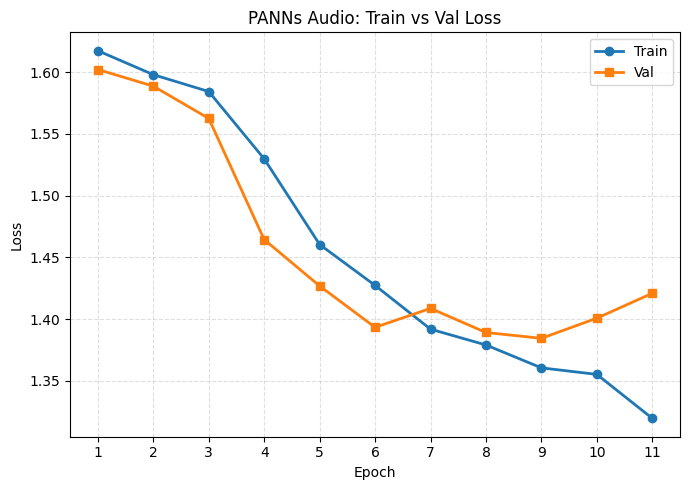

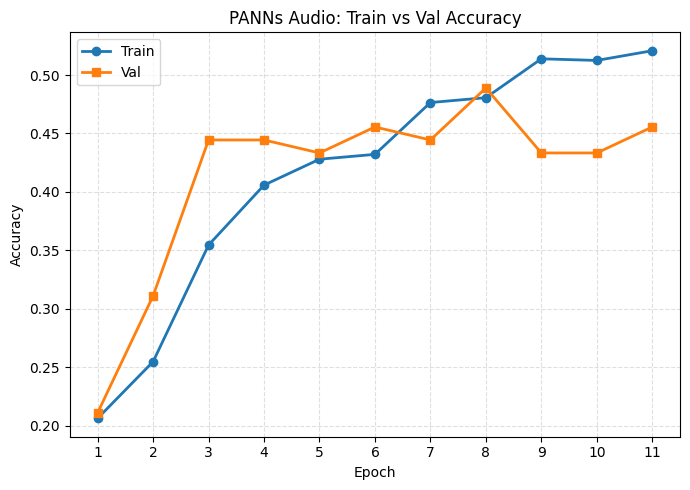

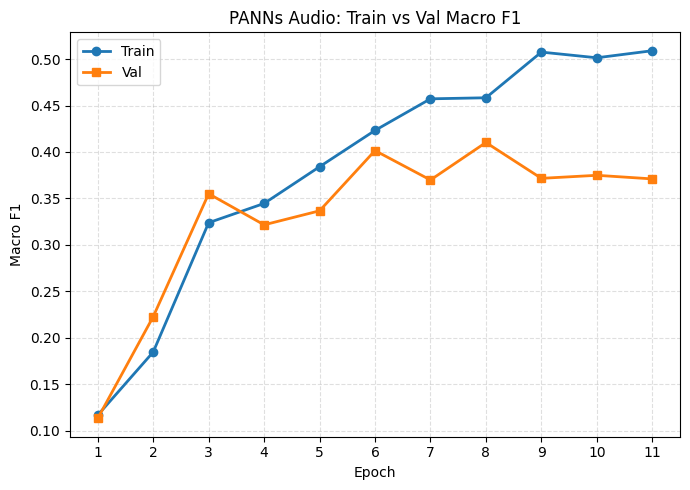

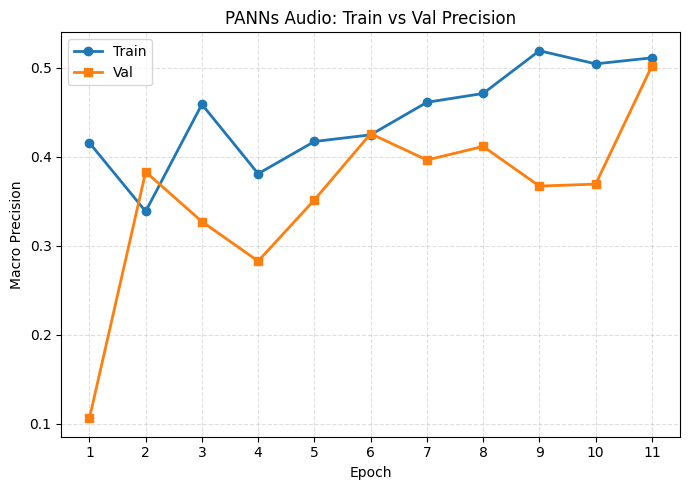

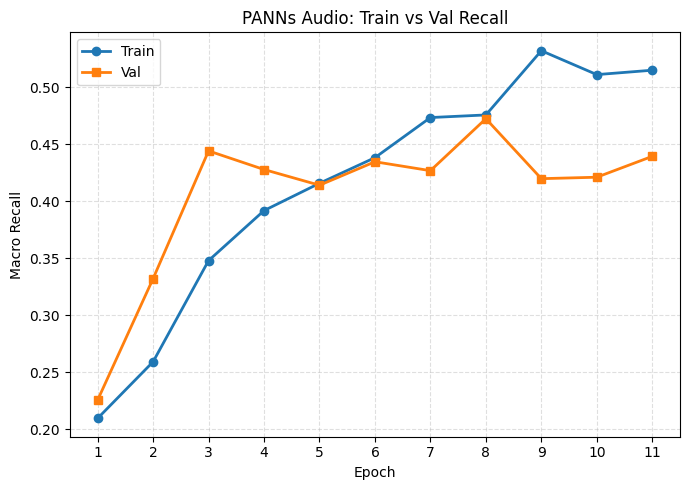

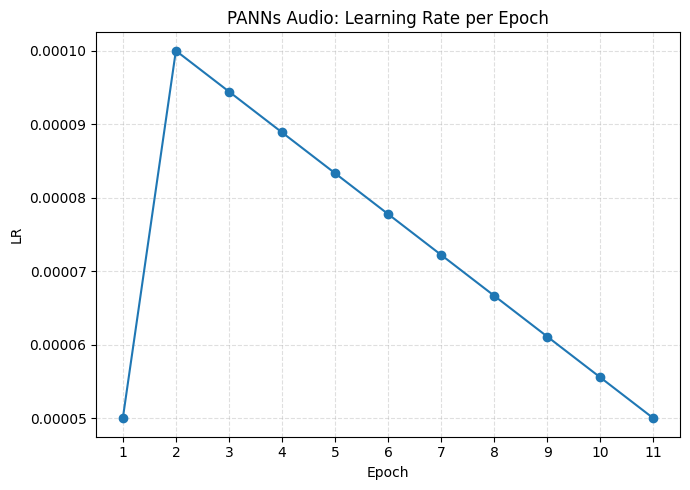

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# simpan history ke CSV
history_pann_df = pd.DataFrame(history_pann)
history_pann_csv_path = SAVE_DIR / "audio_pann_training_history.csv"
history_pann_df.to_csv(history_pann_csv_path, index=False)
print("✅ History training PANNs audio disimpan di:", history_pann_csv_path)

def plot_compare(train_values, val_values, title, ylabel):
    plt.figure(figsize=(7,5))
    epochs = np.arange(1, len(train_values)+1)
    plt.plot(epochs, train_values, marker='o', label='Train', linewidth=2)
    plt.plot(epochs, val_values, marker='s', label='Val', linewidth=2)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_compare(history_pann["train_loss"], history_pann["val_loss"],
             "PANNs Audio: Train vs Val Loss", "Loss")

plot_compare(history_pann["train_acc"], history_pann["val_acc"],
             "PANNs Audio: Train vs Val Accuracy", "Accuracy")

plot_compare(history_pann["train_f1"], history_pann["val_f1"],
             "PANNs Audio: Train vs Val Macro F1", "Macro F1")

plot_compare(history_pann["train_prec"], history_pann["val_prec"],
             "PANNs Audio: Train vs Val Precision", "Macro Precision")

plot_compare(history_pann["train_rec"], history_pann["val_rec"],
             "PANNs Audio: Train vs Val Recall", "Macro Recall")

plt.figure(figsize=(7,5))
epochs = np.arange(1, len(history_pann["lr"])+1)
plt.plot(epochs, history_pann["lr"], marker='o')
plt.title("PANNs Audio: Learning Rate per Epoch")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

PANNs Test Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

🎧 PANNs Audio Test Accuracy: 0.5054945054945055
🎧 PANNs Audio Test Macro F1: 0.4676353400084755
              precision    recall  f1-score   support

           0      0.667     0.235     0.348        17
           1      0.600     0.353     0.444        17
           2      0.486     0.818     0.610        22
           3      0.500     0.263     0.345        19
           4      0.464     0.812     0.591        16

    accuracy                          0.505        91
   macro avg      0.543     0.496     0.468        91
weighted avg      0.540     0.505     0.471        91

Confusion matrix:
 [[ 4  3  2  2  6]
 [ 0  6  8  1  2]
 [ 0  0 18  1  3]
 [ 1  1  8  5  4]
 [ 1  0  1  1 13]]


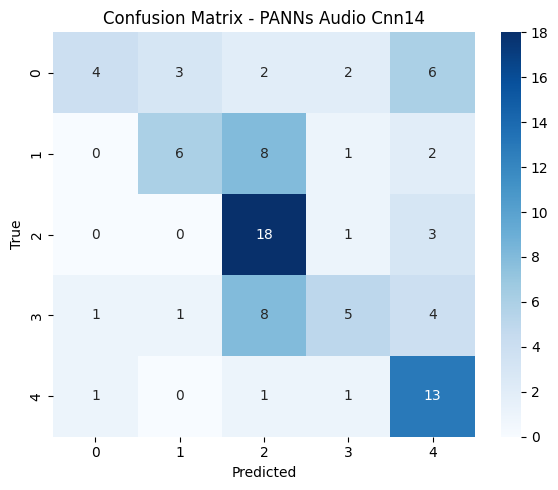

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# load best PANNs model
best_pann_model_path = DATASET_ROOT / "best_audio_pann.pt"
panns_model.load_state_dict(torch.load(best_pann_model_path, map_location=device))
panns_model.eval()

all_test_labels = []
all_test_preds  = []
all_test_probs  = []

with torch.no_grad():
    for audio_multicrop, labels in tqdm(test_loader, desc="PANNs Test Evaluation"):
        # audio_multicrop for test is (batch_size, num_crops, PANN_TARGET_AUDIO_LENGTH)
        labels = labels.to(device)

        num_crops = audio_multicrop.shape[1]
        # Reshape from (batch_size, num_crops, PANN_TARGET_AUDIO_LENGTH) to (batch_size * num_crops, PANN_TARGET_AUDIO_LENGTH)
        reshaped_input = audio_multicrop.view(-1, PANN_TARGET_AUDIO_LENGTH).to(device)

        # Pass through model
        outputs_all_crops_dict = panns_model(reshaped_input)
        outputs_all_crops = outputs_all_crops_dict["clipwise_output"] # Extract the clipwise_output

        # Reshape back to (batch_size, num_crops, NUM_CLASSES) and average across crops
        outputs_per_sample = outputs_all_crops.view(-1, num_crops, NUM_CLASSES)
        avg_outputs = outputs_per_sample.mean(dim=1) # (batch_size, NUM_CLASSES)

        probs = torch.softmax(avg_outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds.detach().cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

acc = accuracy_score(all_test_labels, all_test_preds)
f1  = f1_score(all_test_labels, all_test_preds, average="macro")
print("🎧 PANNs Audio Test Accuracy:", acc)
print("🎧 PANNs Audio Test Macro F1:", f1)
print(classification_report(all_test_labels, all_test_preds, digits=3))

cm = confusion_matrix(all_test_labels, all_test_preds)
print("Confusion matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2,3,4],
            yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - PANNs Audio Cnn14")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Ensure all_test_probs is a numpy array
probs_array = np.array(all_test_probs)

# Extract file IDs for the test set from test_df
# Assuming that the order of all_test_labels/preds/probs corresponds to test_df
all_test_ids = test_df["file_id_norm"].tolist()

# CSV probabilitas untuk fusion
audio_prob_df = pd.DataFrame({
    "id": all_test_ids,
    "true_label": all_test_labels,
})
for i in range(NUM_CLASSES):
    audio_prob_df[f"prob_cluster_{i+1}"] = probs_array[:, i]

audio_prob_path = SAVE_DIR / "audio_prob_for_fusion.csv"
audio_prob_df.to_csv(audio_prob_path, index=False)
print("✅ audio_prob_for_fusion.csv disimpan di:", audio_prob_path)
display(audio_prob_df.head())

# CSV hasil unimodal
audio_unimodal_df = pd.DataFrame({
    "id": all_test_ids,
    "true_label": all_test_labels,
    "pred_label": all_test_preds,
})
for i in range(NUM_CLASSES):
    audio_unimodal_df[f"prob_cluster_{i+1}"] = probs_array[:, i]

audio_unimodal_path = SAVE_DIR / "audio_unimodal_test_results.csv"
audio_unimodal_df.to_csv(audio_unimodal_path, index=False)
print("✅ audio_unimodal_test_results.csv disimpan di:", audio_unimodal_path)
display(audio_unimodal_df.head())

✅ audio_prob_for_fusion.csv disimpan di: /content/drive/MyDrive/dataset_mirex/audiotrainX/audio_prob_for_fusion.csv


,id,true_label,prob_cluster_1,prob_cluster_2,prob_cluster_3,prob_cluster_4,prob_cluster_5
0,15,0,0.233795,0.251258,0.133281,0.193381,0.188286
1,21,0,0.215142,0.139563,0.135969,0.160036,0.349290
2,51,0,0.270709,0.261749,0.145748,0.161911,0.159883
3,55,0,0.165180,0.163014,0.158024,0.174202,0.339581
4,58,0,0.216710,0.191030,0.142935,0.218123,0.231203


✅ audio_unimodal_test_results.csv disimpan di: /content/drive/MyDrive/dataset_mirex/audiotrainX/audio_unimodal_test_results.csv


,id,true_label,pred_label,prob_cluster_1,prob_cluster_2,prob_cluster_3,prob_cluster_4,prob_cluster_5
0,15,0,1,0.233795,0.251258,0.133281,0.193381,0.188286
1,21,0,4,0.215142,0.139563,0.135969,0.160036,0.349290
2,51,0,0,0.270709,0.261749,0.145748,0.161911,0.159883
3,55,0,4,0.165180,0.163014,0.158024,0.174202,0.339581
4,58,0,4,0.216710,0.191030,0.142935,0.218123,0.231203
